# Imports

In [45]:
from os import path, listdir
from copy import deepcopy
import stlearn as st
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import LabelEncoder
import pickle 

%load_ext autoreload
%autoreload 2

from scanpy_stlearn_loaders import StlearnLoader
from results_analysis import pca_kmeans_clustering

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data 

In [11]:
dataset_name = 'Visium_Mouse_Olfactory_Bulb'

## Genes-Spots Expression Values 

In [12]:
obj = StlearnLoader().load_local_visum(path=path.join('/', 'data', dataset_name),
                                      count_file='filtered_feature_bc_matrix.h5')
x = obj.X.toarray()
n_spots, n_genes = x.shape
print(f'# spots: {n_spots} | # genes: {n_genes}')
original_data_obj = deepcopy(obj) # For clustering image
obj

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# spots: 1185 | # genes: 32285


AnnData object with n_obs × n_vars = 1185 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [117]:
obj.obs.sort_values(by=['array_col', 'array_row']).head()

,in_tissue,array_row,array_col,imagecol,imagerow,tile_path
GGATGCTGGCGTTCCT-1,1,39,19,988.6,1517.6,tiles/988.6-1517.6000000000001-40.jpeg
CCCTGCCCAATCCGCT-1,1,41,19,1028.2,1517.6,tiles/1028.2-1517.6000000000001-40.jpeg
TGCCAAAGTCAGACTT-1,1,43,19,1067.6,1517.4,tiles/1067.6000000000001-1517.4-40.jpeg
AAACTTGCAAACGTAT-1,1,45,19,1107.0,1517.4,tiles/1107.0-1517.4-40.jpeg
TACTTTCCGCACGCCA-1,1,47,19,1146.4,1517.4,tiles/1146.4-1517.4-40.jpeg


In [14]:
df_tmp = obj.obs[['array_row', 'array_col']].reset_index(drop=False).rename(columns={'index': 'spot_id'})
df_tmp.head()

,spot_id,array_row,array_col
0,AAACAAGTATCTCCCA-1,50,102
1,AAACCGGGTAGGTACC-1,42,28
2,AAACCGTTCGTCCAGG-1,52,42
3,AAACGAGACGGTTGAT-1,35,79
4,AAACTGCTGGCTCCAA-1,45,67


array_row,29,30,31,32,33,34,35,36,37,38,...,53,54,55,56,57,58,59,60,61,62
array_col,,,,,,,,,,,,,,,,,,,,,
19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CCGATTCGAGGGACCC-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CCAGCTGATGGTACTT-1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AATATTGGAGTATTGA-1,NaN,GACAGGCACACACTAT-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GGCCCTCACCCACTTA-1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GTGCGACAGGGAGTGT-1,NaN,ACCCGGATGACGCATC-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CCGATCTCAACCTTAT-1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


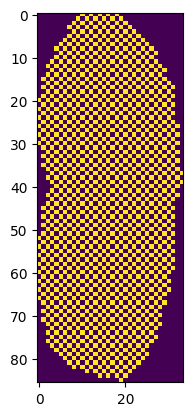

In [15]:
df_tmp2 = df_tmp.copy()
df_tmp2['spot_id'] = 255
df_tmp2 = df_tmp2.pivot(index='array_col', columns='array_row', values='spot_id')
display(plt.imshow(df_tmp2.fillna(0)))
df_tmp.pivot(index='array_col', columns='array_row', values='spot_id')

## Spatial Images 

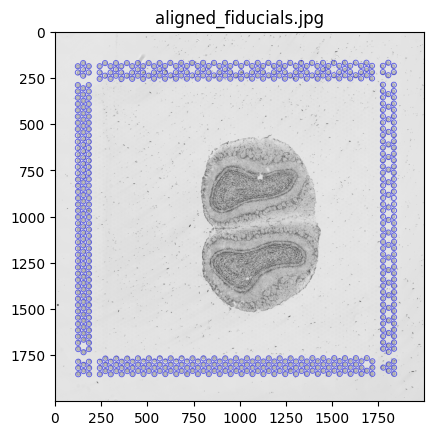

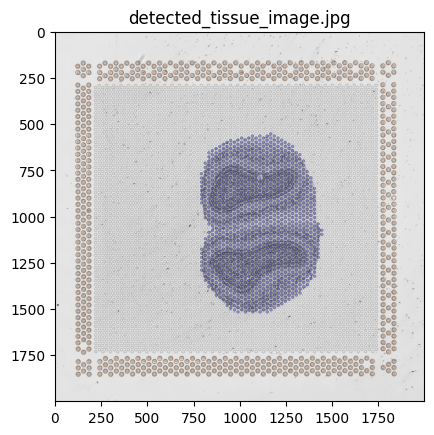

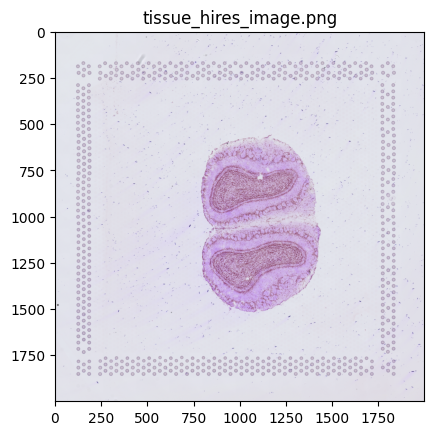

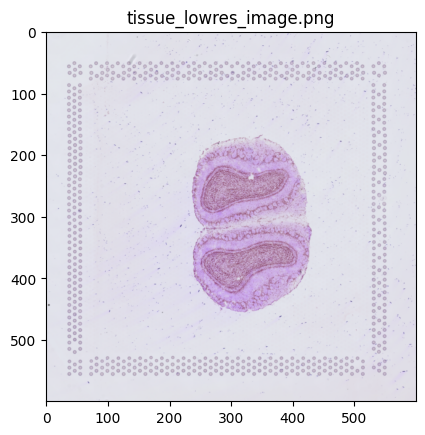

Spots:


,in_tissue,array_row,array_col,imagecol,imagerow
AAACAAGTATCTCCCA-1,1,50,102,1204.4,577.4
AAACCGGGTAGGTACC-1,1,42,28,1047.6,1415.6
AAACCGTTCGTCCAGG-1,1,52,42,1244.6,1256.8
AAACGAGACGGTTGAT-1,1,35,79,909.2,838.2
AAACTGCTGGCTCCAA-1,1,45,67,1106.4,973.8


In [16]:
# Low resolution Images
spatial_dir = path.join('/', 'data', dataset_name, 'spatial')
for img in [k for k in listdir(spatial_dir) if k.endswith('.jpg') or k.endswith('.png')]:
    plt.title(img)
    plt.imshow(cv2.imread(path.join(spatial_dir, img)))
    plt.show()
    
print('Spots:')
display(obj.obs.head())

## Full Resolution Image 

In [ ]:
# Full Resultion Image

from PIL import Image
image_path = path.join('/', 'data', dataset_name, 'image.tif')
im = Image.open(image_path)
image_array = np.array(im)
im.show()

# Filter Genes
- min_cells = Keep genes with at least X spots with non zero expression (x[spot, gene] > 0)
- min_counts = Keep genes with at least X expressions (sum of expression over all spots) (sum(x[:, gene]) > X)

In [41]:
obj = StlearnLoader().load_local_visum(path=path.join('/', 'data', dataset_name),
                                      count_file='filtered_feature_bc_matrix.h5')

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [42]:
# Keep genes with at least 177 non zero spots
min_cells = 177
print(f'Keep genes with at least {min_cells} non zero spots')
st.pp.filter_genes(obj, min_cells=min_cells)
x = obj.X.toarray()
n_spots, n_genes = x.shape
print(f'# spots: {n_spots} | # genes: {n_genes}')

Keep genes with at least 177 non zero spots
# spots: 1185 | # genes: 9528


In [43]:
min_counts = 500
print(f'Keep genes with total expression of at least {min_counts} over all spots')
st.pp.filter_genes(obj, min_counts=min_counts)
x = obj.X.toarray()
n_spots, n_genes = x.shape
print(f'# spots: {n_spots} | # genes: {n_genes}')

Keep genes with total expression of at least 500 over all spots
# spots: 1185 | # genes: 6279


In [44]:
filtered_data_obj = deepcopy(obj) # For clustering image
nmf_train_data_obj = deepcopy(filtered_data_obj) # For clustering image
ae_train_data_obj = deepcopy(filtered_data_obj) # For clustering image

# EDA 

## Genes - Spots Info

In [ ]:
print('Spots information')
display(obj.obs.head())
print('Genes information')
display(obj.var.head())

In [ ]:
print(f'All the spots in the matrix are in the tissue: "in_tissue" # unique values = {obj.obs.in_tissue.nunique()}')
print(f'All the genes are from the same genome: "genome" # unique values = {obj.var.genome.nunique()}')

## Expression over spots 

In [ ]:
def total_exp_over_spots(x):
    plt.figure(figsize=(15, 6))
    spots_total_exp = x.sum(axis=1)
    sns.histplot(spots_total_exp)
    plt.title('Total expression in spots (Histogram)')
    plt.xlabel('Total Expression')
    plt.ylabel('# of spots')
    plt.show()

In [ ]:
total_exp_over_spots(x)

In [ ]:
def spots_sparsity(x):
    plt.figure(figsize=(15, 6))
    spots_exp_sparsity = (x.shape[1] - np.count_nonzero(x, axis=1)) / x.shape[1]
    sns.histplot(spots_exp_sparsity)
    plt.title('Spots Expression Sparsity (Histogram)')
    plt.xlabel('% Sparsity (% of genes with zero expression)')
    plt.ylabel('# of spots')
    plt.show()

In [ ]:
spots_sparsity(x)

## Expression over genes

In [ ]:
def total_exp_over_genes(x, logx=True, logy=True):
    plt.figure(figsize=(15, 6))
    genes_total_exp = x.sum(axis=0)
    sns.histplot(genes_total_exp)
    plt.title('Total expression in genes (Histogram)')
    plt.xlabel('Total Expression')
    plt.ylabel('# of genes')
    if logy:
        plt.yscale('log')
    if logx:
        plt.xscale('log')
    plt.show()

In [ ]:
total_exp_over_genes(x)

In [ ]:
def genes_sparsity(x):
    plt.figure(figsize=(15, 6))
    genes_exp_sparsity = (x.shape[0] - np.count_nonzero(x, axis=0)) / x.shape[0]
    sns.histplot(genes_exp_sparsity)
    plt.title('Genes Expression Sparsity (Histogram)')
    plt.xlabel('% Sparsity (% of spots with zero expression)')
    plt.ylabel('# of genes')
    plt.show()

In [ ]:
genes_sparsity(x)

## Unstructred 

In [ ]:
obj_unstructred = obj.uns['spatial']['Visium_Mouse_Olfactory_Bulb']

In [ ]:
print(f"Scale factors: \n{obj_unstructred['scalefactors']}")
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 8))
ax1.imshow(obj_unstructred['images']['hires'])
ax1.set_title('Hires Image')
ax2.imshow(obj_unstructred['images']['lowres'])
ax2.set_title('Lowres Image')
plt.show()

## Genes Expressions 

### Top N Expressed Genes 

In [ ]:
N = 10
genes_expressed = np.sum(x, axis=0) / (np.count_nonzero(x, axis=0) + 1)
top_genes_indices = genes_expressed.argsort()[-N:][::-1]
top_genes_names = obj.var.index[top_genes_indices]
print(top_genes_names)
top_genes_expression = x[:, top_genes_indices]
top_genes_expression.shape

In [ ]:
tmp = pd.DataFrame(top_genes_expression, columns=top_genes_names)
tmp.plot.box(figsize=(15, 9), title='Top expressed genes', rot=90)
plt.show()

In [ ]:
for gene_symbol in top_genes_names:
    st.pl.gene_plot(obj, gene_symbols=gene_symbol, size=20, figsize=(12, 9))
    plt.show()

## Log expression 

In [ ]:
st.pp.log1p(obj)
scaled_x = obj.X.toarray()
obj

In [ ]:
total_exp_over_spots(scaled_x)
total_exp_over_genes(scaled_x, logx=False, logy=False)

# PCA + KMeans Clustering 

## Original Dataset
All genes

Normalization step is finished in adata.X
Log transformation step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']
Applying Kmeans clustering ...
Kmeans clustering is done! The labels are stored in adata.obs["kmeans"]


<Figure size 640x480 with 0 Axes>

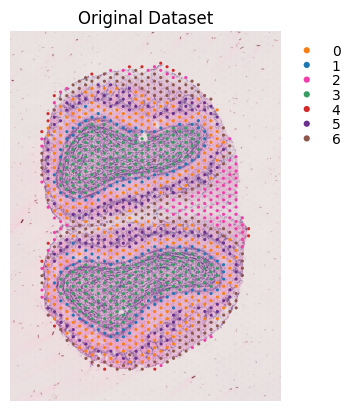

In [13]:
pca_kmeans_clustering(
    data_obj=original_data_obj, 
    title='Original Dataset'
)

## Filtered Dataset (6279 Genes)
- Keep genes with at least 177 non zero spots
- Keep genes with total expression of at least 500 over all spots

Normalization step is finished in adata.X
Log transformation step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']
Applying Kmeans clustering ...
Kmeans clustering is done! The labels are stored in adata.obs["kmeans"]


<Figure size 640x480 with 0 Axes>

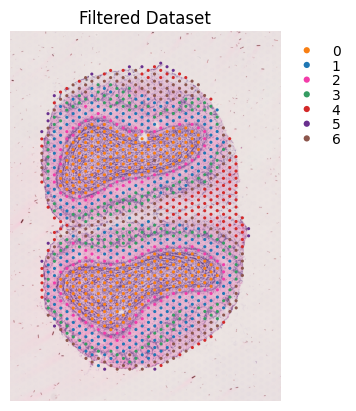

In [24]:
pca_kmeans_clustering(
    data_obj=filtered_data_obj, 
    title='Filtered Dataset'
)

## Train Dataset
Filtered dataset with extra 20% of zero expressions

In [91]:
# Load NMF and AE Dataloaders
dl_train_nmf = torch.load(path.join('/', 'data', 'NMF', 'dl_train.pth'))
dl_train_ae = torch.load(path.join('/', 'data', 'AE', 'dl_train.pth'))

# Load Ordinal Encoders
with open(path.join('/', 'data', 'NMF', 'genes_encoder.pkl'), 'rb') as f:
    nmf_oe_genes = pickle.load(f)
with open(path.join('/', 'data', 'NMF', 'spots_encoder.pkl'), 'rb') as f:
    nmf_oe_spots = pickle.load(f)
    
with open(path.join('/', 'data', 'AE', 'genes_encoder.pkl'), 'rb') as f:
    ae_oe_genes = pickle.load(f)
with open(path.join('/', 'data', 'AE', 'spots_encoder.pkl'), 'rb') as f:
    ae_oe_spots = pickle.load(f)

### NMF

In [88]:
nmf_train_genes, nmf_train_spots, nmf_train_expressions = dl_train_nmf.dataset.get_all_data()
df_nmf_train = pd.DataFrame({'gene': nmf_train_genes, 'spot': nmf_train_spots, 'expression': nmf_train_expressions})
df_nmf_train[['gene']] = nmf_oe_genes.inverse_transform(df_nmf_train[['gene']].values)
df_nmf_train[['spot']] = nmf_oe_spots.inverse_transform(df_nmf_train[['spot']].values)
df_nmf_train_matrix = df_nmf_train.pivot(index='spot', columns='gene', values='expression')
display(df_nmf_train_matrix.head())
tmp_genes_locations = [nmf_train_data_obj.var.index.get_loc(key=gene_key) for gene_key in df_nmf_train_matrix.columns]
# Replace the values
nmf_train_data_obj.X[:, tmp_genes_locations] = df_nmf_train_matrix.values

gene,0610009B22Rik,0610009L18Rik,0610010K14Rik,0610012G03Rik,1110004F10Rik,1110008P14Rik,1110032A03Rik,1110038B12Rik,1110038F14Rik,1110051M20Rik,...,mt-Co1,mt-Co2,mt-Co3,mt-Cytb,mt-Nd1,mt-Nd2,mt-Nd3,mt-Nd4,mt-Nd4l,mt-Nd5
spot,,,,,,,,,,,,,,,,,,,,,
AAACAAGTATCTCCCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,28.0,0.0,28.0,9.0,8.0,0.0,22.0,0.0,1.0
AAACCGGGTAGGTACC-1,0.0,0.0,0.0,2.0,3.0,7.0,7.0,3.0,1.0,2.0,...,1587.0,962.0,1292.0,571.0,0.0,318.0,58.0,476.0,9.0,31.0
AAACCGTTCGTCCAGG-1,0.0,1.0,5.0,0.0,7.0,0.0,3.0,0.0,0.0,8.0,...,832.0,0.0,761.0,339.0,237.0,0.0,42.0,0.0,3.0,20.0
AAACGAGACGGTTGAT-1,0.0,0.0,6.0,4.0,12.0,3.0,1.0,0.0,3.0,0.0,...,0.0,305.0,562.0,262.0,178.0,0.0,25.0,175.0,3.0,0.0
AAACTGCTGGCTCCAA-1,1.0,0.0,2.0,4.0,5.0,0.0,0.0,0.0,0.0,5.0,...,0.0,452.0,0.0,0.0,191.0,0.0,34.0,0.0,0.0,27.0


Normalization step is finished in adata.X
Log transformation step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']
Applying Kmeans clustering ...
Kmeans clustering is done! The labels are stored in adata.obs["kmeans"]


<Figure size 640x480 with 0 Axes>

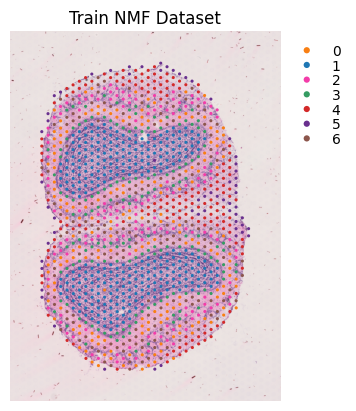

In [90]:
pca_kmeans_clustering(
    data_obj=nmf_train_data_obj, 
    title='Train NMF Dataset'
)

### AE 

In [117]:
ae_train_matrix, _ = dl_train_ae.dataset.get_all_data()
df_ae_train_matrix = pd.DataFrame(ae_train_matrix.T)
df_ae_train_matrix.columns = ae_oe_genes.inverse_transform(df_ae_train_matrix.columns.values.reshape(-1, 1)).reshape(1, -1)[0]
df_ae_train_matrix.index = ae_oe_spots.inverse_transform(df_ae_train_matrix.index.values.reshape(-1, 1)).reshape(1, -1)[0]
display(df_ae_train_matrix.head())
tmp_genes_locations = [ae_train_data_obj.var.index.get_loc(key=gene_key) for gene_key in df_ae_train_matrix.columns]
# Replace the values
ae_train_data_obj.X[:, tmp_genes_locations] = df_ae_train_matrix.values

,0610009B22Rik,0610009L18Rik,0610010K14Rik,0610012G03Rik,1110004F10Rik,1110008P14Rik,1110032A03Rik,1110038B12Rik,1110038F14Rik,1110051M20Rik,...,mt-Co1,mt-Co2,mt-Co3,mt-Cytb,mt-Nd1,mt-Nd2,mt-Nd3,mt-Nd4,mt-Nd4l,mt-Nd5
AAACAAGTATCTCCCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,62.0,0.0,0.0,28.0,0.0,0.0,4.0,22.0,0.0,1.0
AAACCGGGTAGGTACC-1,1.0,0.0,2.0,2.0,3.0,0.0,7.0,3.0,1.0,0.0,...,0.0,0.0,1292.0,571.0,0.0,0.0,58.0,476.0,9.0,0.0
AAACCGTTCGTCCAGG-1,0.0,1.0,0.0,6.0,7.0,4.0,0.0,1.0,0.0,8.0,...,0.0,488.0,761.0,339.0,237.0,0.0,42.0,278.0,0.0,0.0
AAACGAGACGGTTGAT-1,1.0,0.0,6.0,4.0,12.0,3.0,1.0,0.0,3.0,0.0,...,575.0,305.0,0.0,0.0,0.0,0.0,25.0,175.0,0.0,0.0
AAACTGCTGGCTCCAA-1,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,452.0,691.0,306.0,191.0,157.0,0.0,0.0,1.0,0.0


/usr/local/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Normalization step is finished in adata.X
Log transformation step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']
Applying Kmeans clustering ...
Kmeans clustering is done! The labels are stored in adata.obs["kmeans"]


<Figure size 640x480 with 0 Axes>

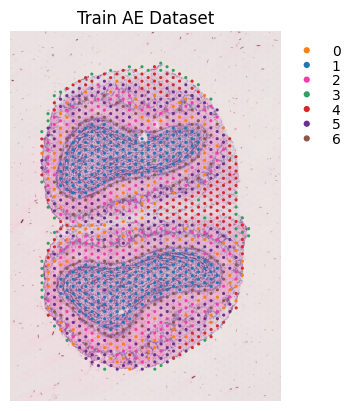

In [120]:
pca_kmeans_clustering(
    data_obj=ae_train_data_obj, 
    title='Train AE Dataset'
)